# VQE-based Integer Factorization (N = 35)
This notebook implements a Qiskit version of a hybrid quantum-classical VQE-based algorithm to factorize composite numbers N. <br /><br />
Optimizers (qiskit_algorithms.optimizers): <br />
https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html

In [1]:
import sys, time
print(sys.executable)  # display current environment

/opt/anaconda3/envs/vqe-env2/bin/python


In [2]:
from qiskit import QuantumCircuit, transpile  # build and compile quantum circuits
from qiskit_aer import Aer  # Qiskit simulator backend
from qiskit.circuit import ParameterVector  # def symbolic parameters(e.g., θ₀, θ₁...) for variational circuits
import numpy as np  # numerical operations
from qiskit_algorithms.optimizers import (  # optimizers for hybrid quantum-classical optimization
    COBYLA,           # Constrained Optimization By Linear Approximation
    SPSA,             # Simultaneous Perturbation Stochastic Approximation
    BOBYQA,           # Bound Optimization By Quadratic Approximation
    GSLS,             # Gaussian-smoothed Line Search
    GradientDescent,  # Gradient Descent
    NELDER_MEAD,      # Nelder-Mead optimizer
    NFT,              # Nakanishi–Fujii–Todo
    L_BFGS_B,         # Limited-memory BFGS Bound
    POWELL,           # Powell optimizer
    ADAM,             # Adam and AMSGRAD optimizers
    CG,               # Conjugate Gradient
    UMDA              # Univariate Marginal Distribution Algorithm
)
from collections import Counter, defaultdict  # counting and accumulating results
import matplotlib.pyplot as plt  # visualizing results

In [3]:
# ------------------------------
# 1. Configuration
# ------------------------------

TARGET_N = 35  # the integer to be factored
# SHOTS = 1024
# CVaR_ALPHA = 0.2

## Step 1: Define the variational ansatz

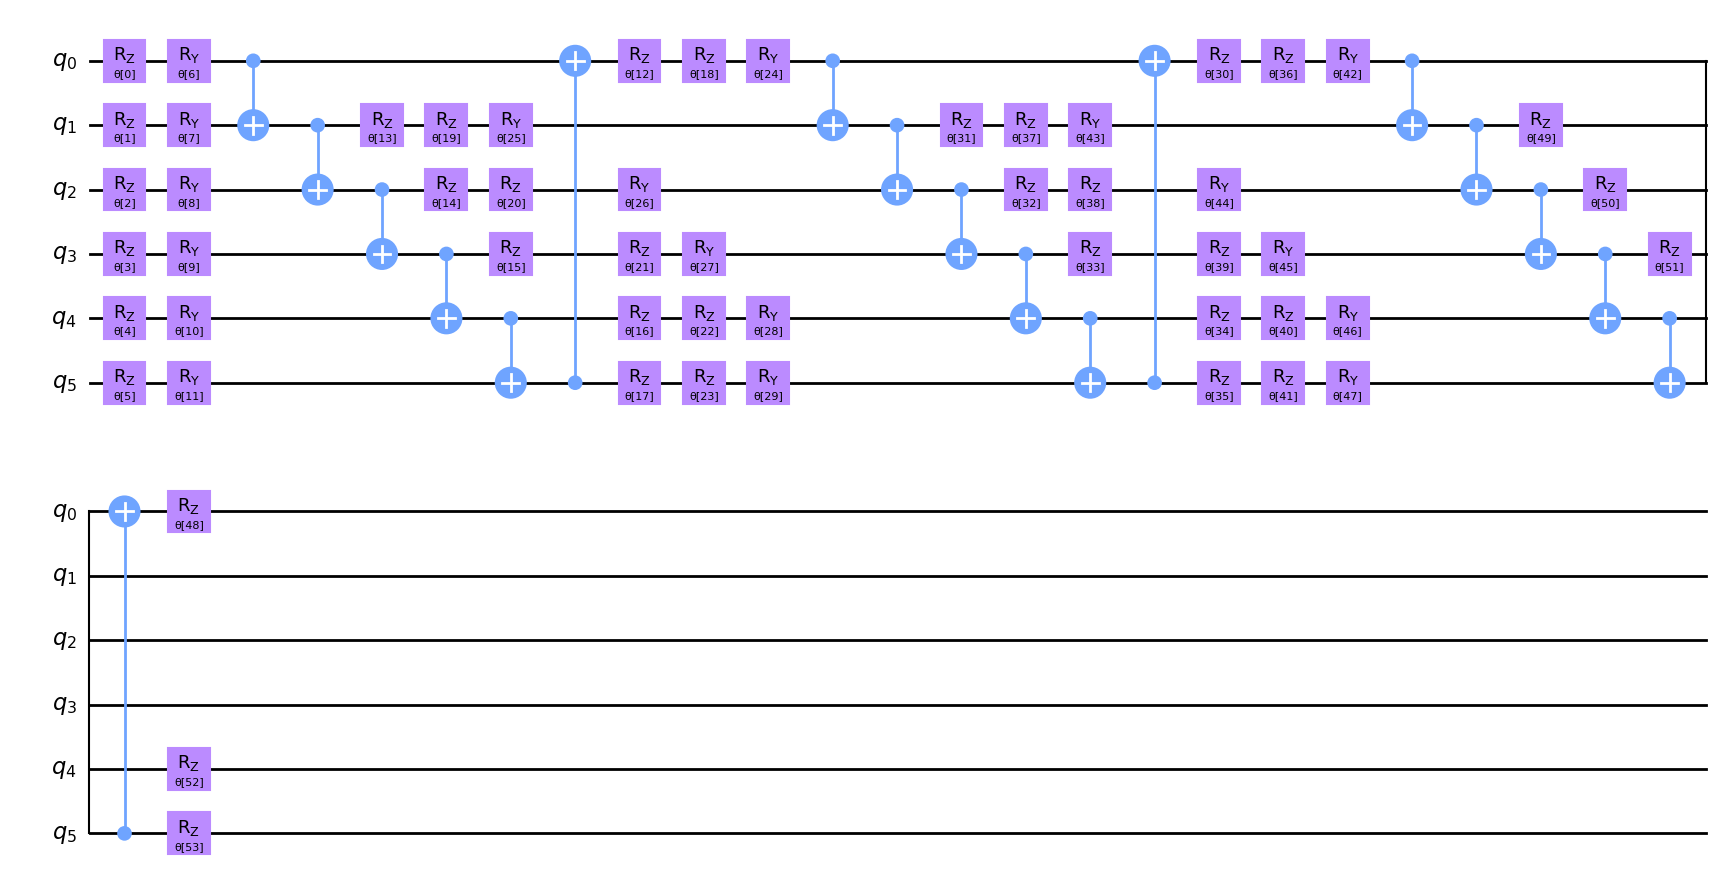

In [4]:
# ------------------------------
# 2. Ansatz Construction
# ------------------------------

def build_ansatz(n_qubits, depth=3):  # build variational circuit ansatz, containing multiple layers of Rz, CX
    params = ParameterVector("θ", length=n_qubits * 3 * depth)     # symbolic parameter vector: θ₀, θ₁, …, θₙ₋₁
    qc = QuantumCircuit(n_qubits)                                  # build quantum circuit with n_qubits qubits

    for d in range(depth):                                         # apply multiple layers(Rz, Ry gate) to each qubit
        for i in range(n_qubits):                                  # apply Rz, Ry gates to each qubit
            qc.rz(params[d * n_qubits * 3 + i], i)                 # apply Rz gate to qubit i
            qc.ry(params[d * n_qubits * 3 + n_qubits + i], i)      # apply Ry gate to qubit i
            
        for i in range(n_qubits):                                  # use circular entanglement structure
            qc.cx(i, (i + 1) % n_qubits)                           # apply CX gate to qubit i and (i+1)%n
            
        for i in range(n_qubits):                                  # apply extra layer as optional enhancement
            qc.rz(params[d * n_qubits * 3 + 2 * n_qubits + i], i)  # apply Rz gate to qubit i

    return qc, params

ansatz, params = build_ansatz(6)  # build ansatz with 6 qubits and draw the circuit
ansatz.draw("mpl")

## Step 2: Cost function to evaluate (x * y - N)^2

In [5]:
# ------------------------------
# 3. Utilities
# ------------------------------

def binary_to_xy(bitstring):                          # convert 6-bit string into two integer values (x, y)
    b = [int(x) for x in bitstring]                   # convert each character into an integer (list of bits)
    x = 2 + b[0] + 2 * b[1] + 4 * b[2]                # decode bits 0–2 into x using binary-weighted formula
    y = 2 + b[3] + 2 * b[4] + 4 * b[5]                # decode bits 3–5 into y using binary-weighted formula
    return x, y

def cost_function(counts, alpha=0.2):                 # calculate the CVaR loss from measurement results
    shots = sum(counts.values())                      # total number of measurement shots
    cost_list = []                                    # store cost values for each measurement result
    correct_factors = []                              # store correct (x, y) pairs satisfying x * y = TARGET_N

    for bitstring, count in counts.items():           # iterate through all measurement results
        x, y = binary_to_xy(bitstring[::-1])          # convert the bitstring to (x, y) pair
        cost = ((x * y - TARGET_N) ** 2)              # calculate the squared error between x * y and TARGET_N
        cost_list.extend([cost] * count)              # extend the list with cost_value for each measurement result
        if x * y == TARGET_N:                         # check if the measurement result is a correct factor
            correct_factors.extend([(x, y)] * count)  # add result to the list with its count

    cost_list.sort()                                  # sort the cost list in ascending order
    cutoff = int(alpha * shots)                       # calculate the cutoff index based on the confidence level
    cvar_cost = np.mean(cost_list[:cutoff]) if cutoff > 0 else np.mean(cost_list)  # calculate CVaR cost

    if correct_factors:                               # if there are correct factors
        counter = Counter(correct_factors)            # count the occurrences of each factor
        (x, y), cnt = counter.most_common(1)[0]       # get the most common factor and its count
        confidence = cnt / shots                      # output the factor with the highest confidence level
    return cvar_cost

## Step 3: Expectation wrapper using measurement results

In [6]:
# ------------------------------
# 4. Expectation Function
# ------------------------------

backend = Aer.get_backend("aer_simulator")   # initialize simulator backend
final_xy_counter = defaultdict(int)          # used to accumulate the counts of (x, y)

def expectation(theta_vals):                 # called by optimizer, executing the circuit and calculating the CVaR cost
    global final_xy_counter                  # use the global variable final_xy_counter to accumulate the counts of (x, y)
    final_xy_counter.clear()                 # clear the counter for the next execution

    # after each execution, new theta_vals is generated and params are bound to ansatz
    bound = ansatz.assign_parameters({params[i]: theta_vals[i] for i in range(len(params))}).copy()
    bound.measure_all()                      # apply full measurements
    compiled = transpile(bound, backend)     # compile and send to simulator
    job = backend.run(compiled, shots=1024)  # run the circuit on the simulator
    counts = job.result().get_counts()       # get the measurement results

    for b, c in counts.items():              # accumulate the counts of (x, y)
        x, y = binary_to_xy(b[::-1])         # convert the bitstring to (x, y) pair
        final_xy_counter[(x, y)] += c        # add the count to the final_xy_counter

    return cost_function(counts)             # return the CVaR cost

## Step 4: Run classical optimizer


Optimizer: COBYLA
Iterations: None
Function evaluations: 200
Elapsed time: 0.80 seconds
Best cost: 0.0

Best parameterized circuit:


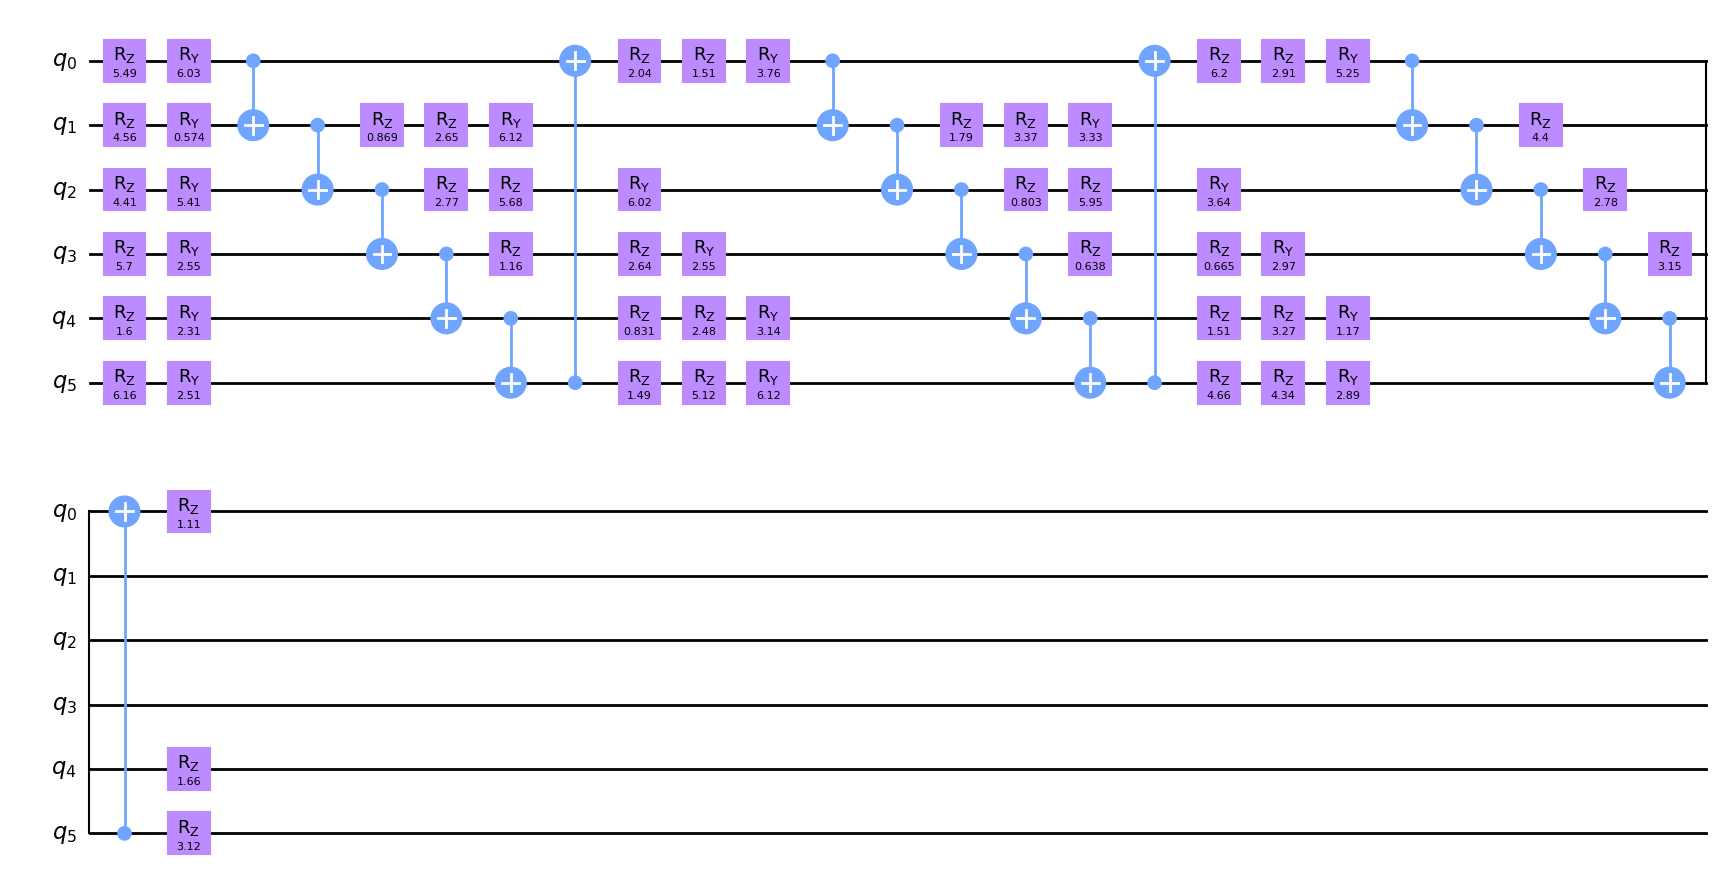


Optimizer: SPSA
Iterations: 500
Function evaluations: 1000
Elapsed time: 4.33 seconds
Best cost: 0.0

Best parameterized circuit:


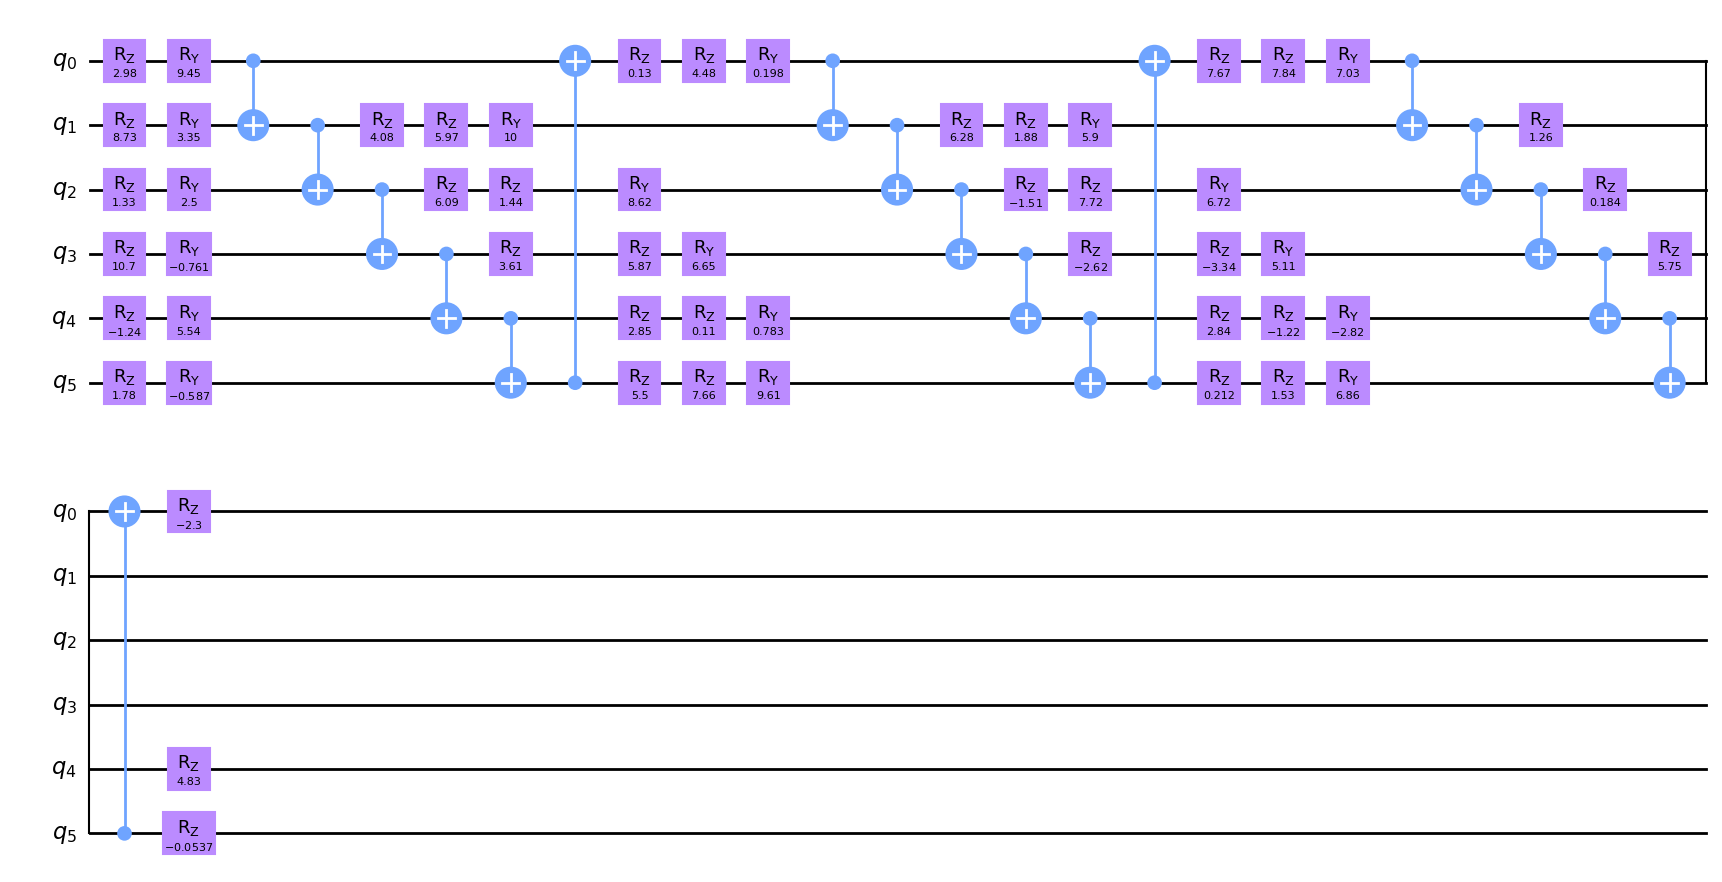

/opt/anaconda3/envs/vqe-env2/lib/python3.9/site-packages/pybobyqa/solver.py:780: RuntimeWarning: maxfun <= npt: Are you sure your budget is large enough?
  warnings.warn("maxfun <= npt: Are you sure your budget is large enough?", RuntimeWarning)



Optimizer: BOBYQA
Iterations: None
Function evaluations: 500
Elapsed time: 2.12 seconds
Best cost: 0.0

Best parameterized circuit:


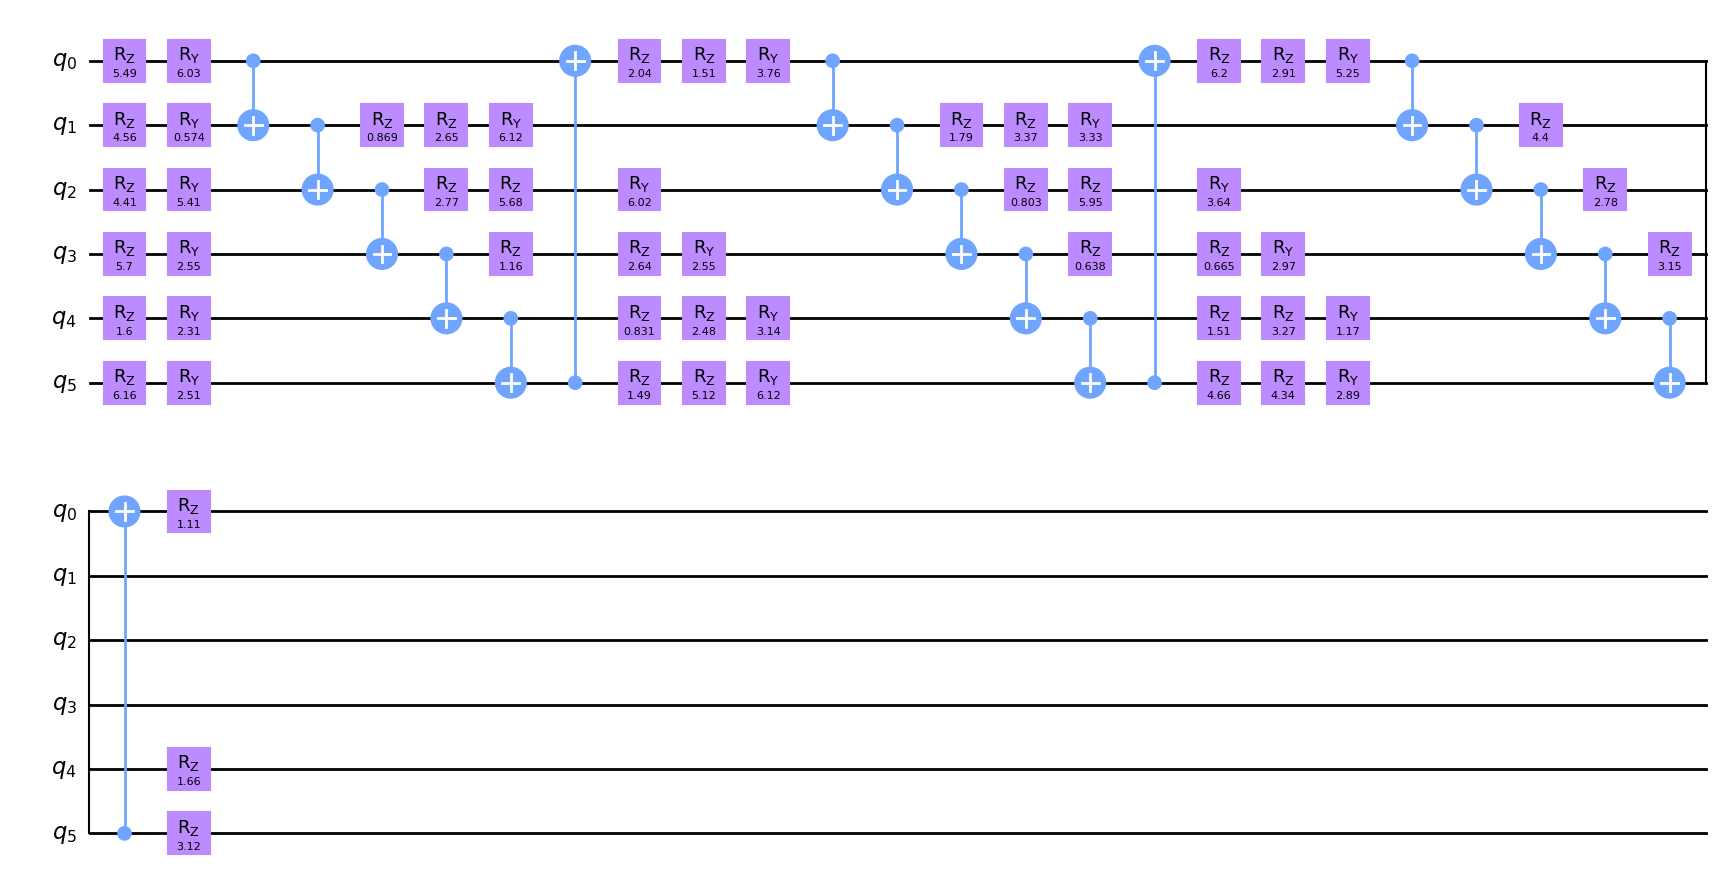


Optimizer: GSLS
Iterations: None
Function evaluations: 1156
Elapsed time: 4.56 seconds
Best cost: 0.0

Best parameterized circuit:


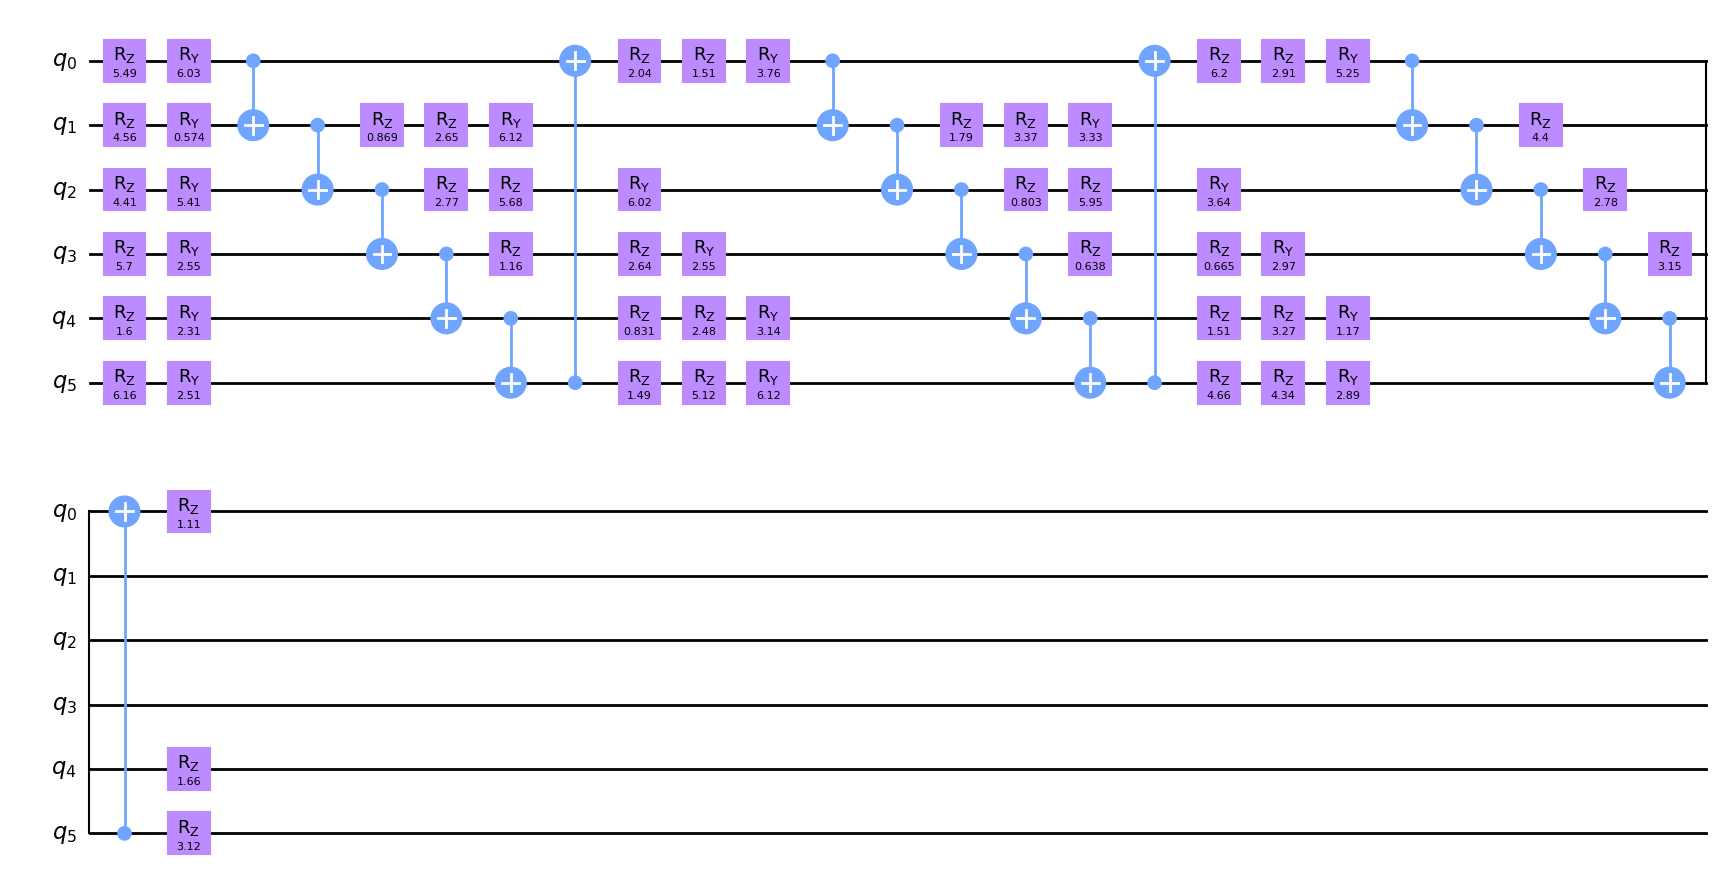


Optimizer: GradientDescent
Iterations: 26
Function evaluations: 1430
Elapsed time: 5.64 seconds
Best cost: 0.0

Best parameterized circuit:


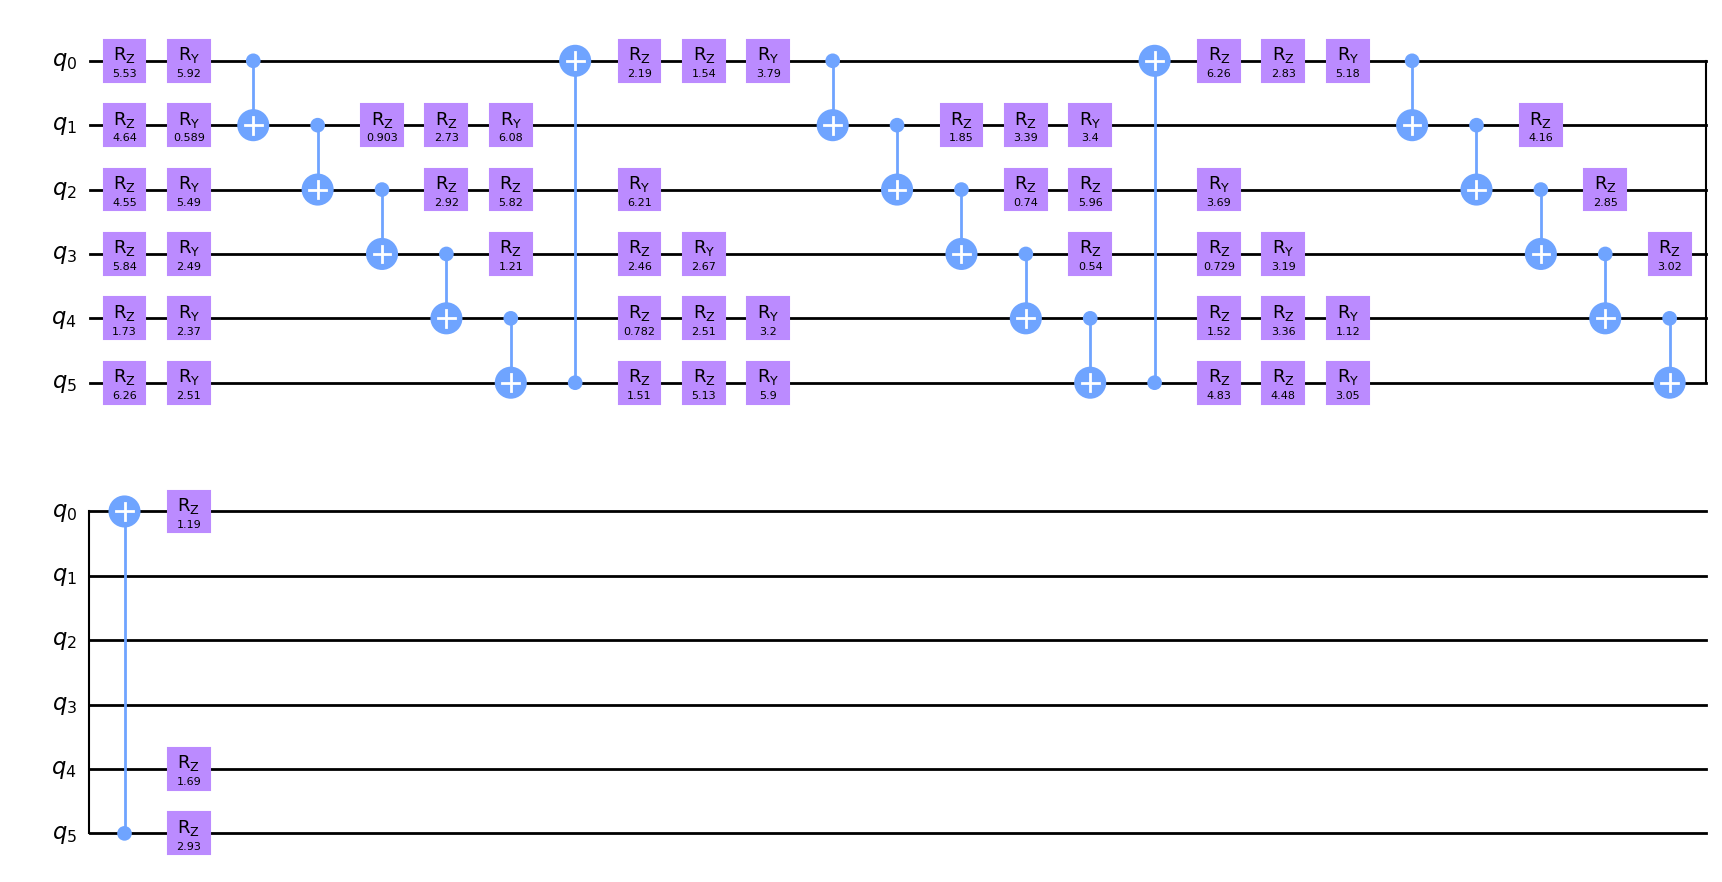


Optimizer: NELDER_MEAD
Iterations: 64
Function evaluations: 847
Elapsed time: 3.32 seconds
Best cost: 0.0

Best parameterized circuit:


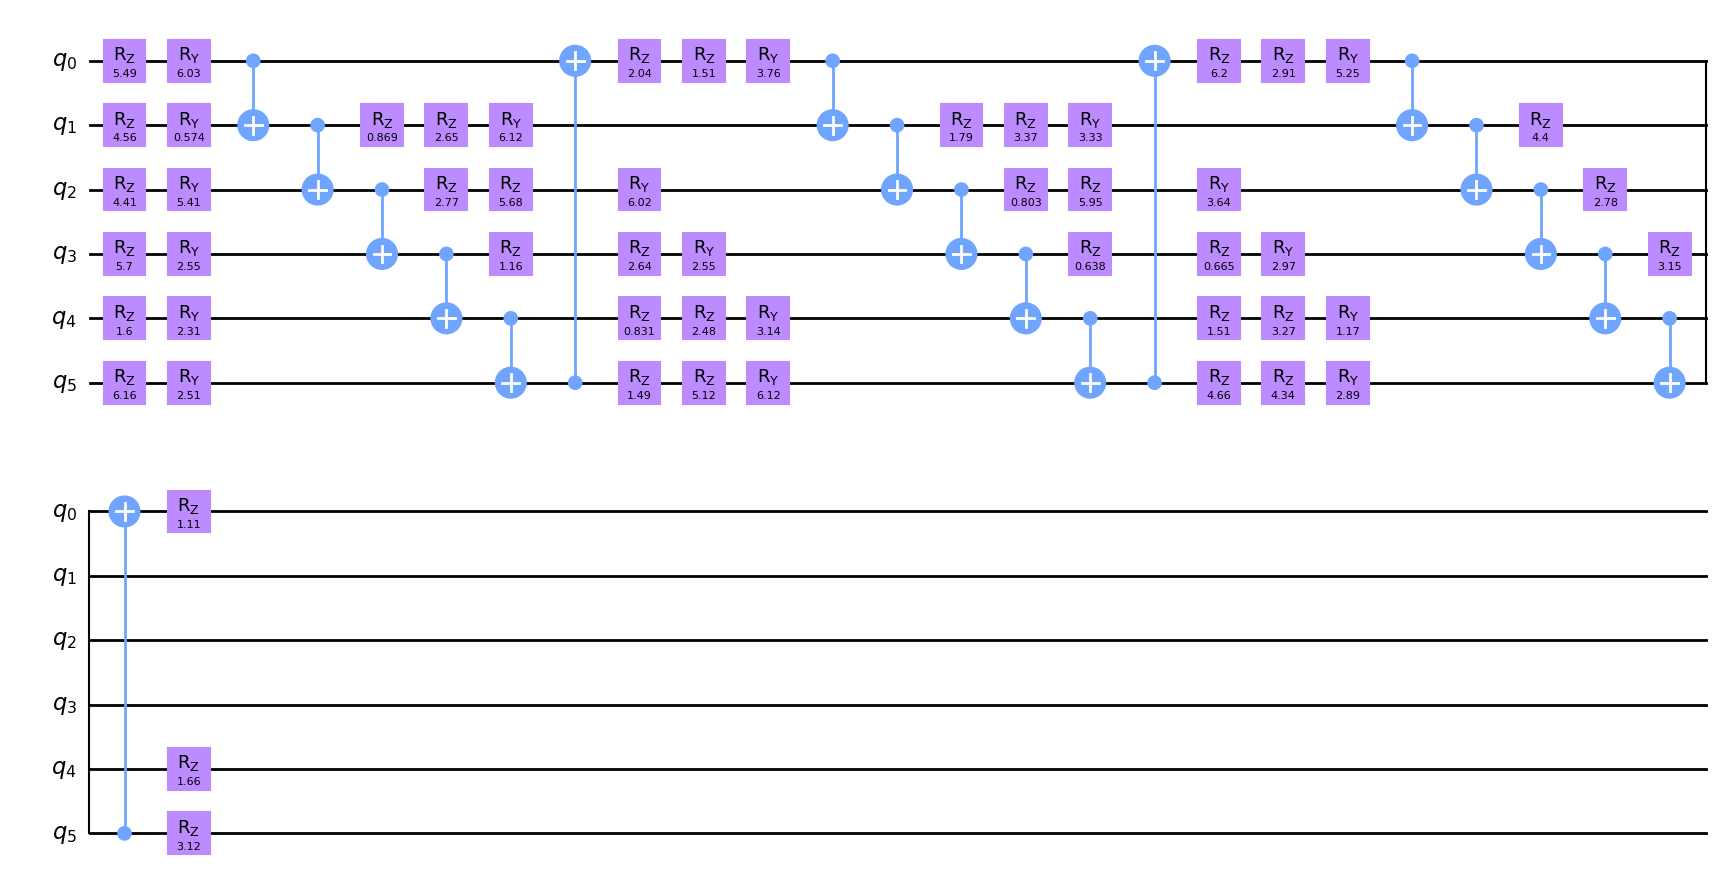


Optimizer: NFT
Iterations: 200
Function evaluations: 407
Elapsed time: 1.59 seconds
Best cost: 0.9950980392156863

Best parameterized circuit:


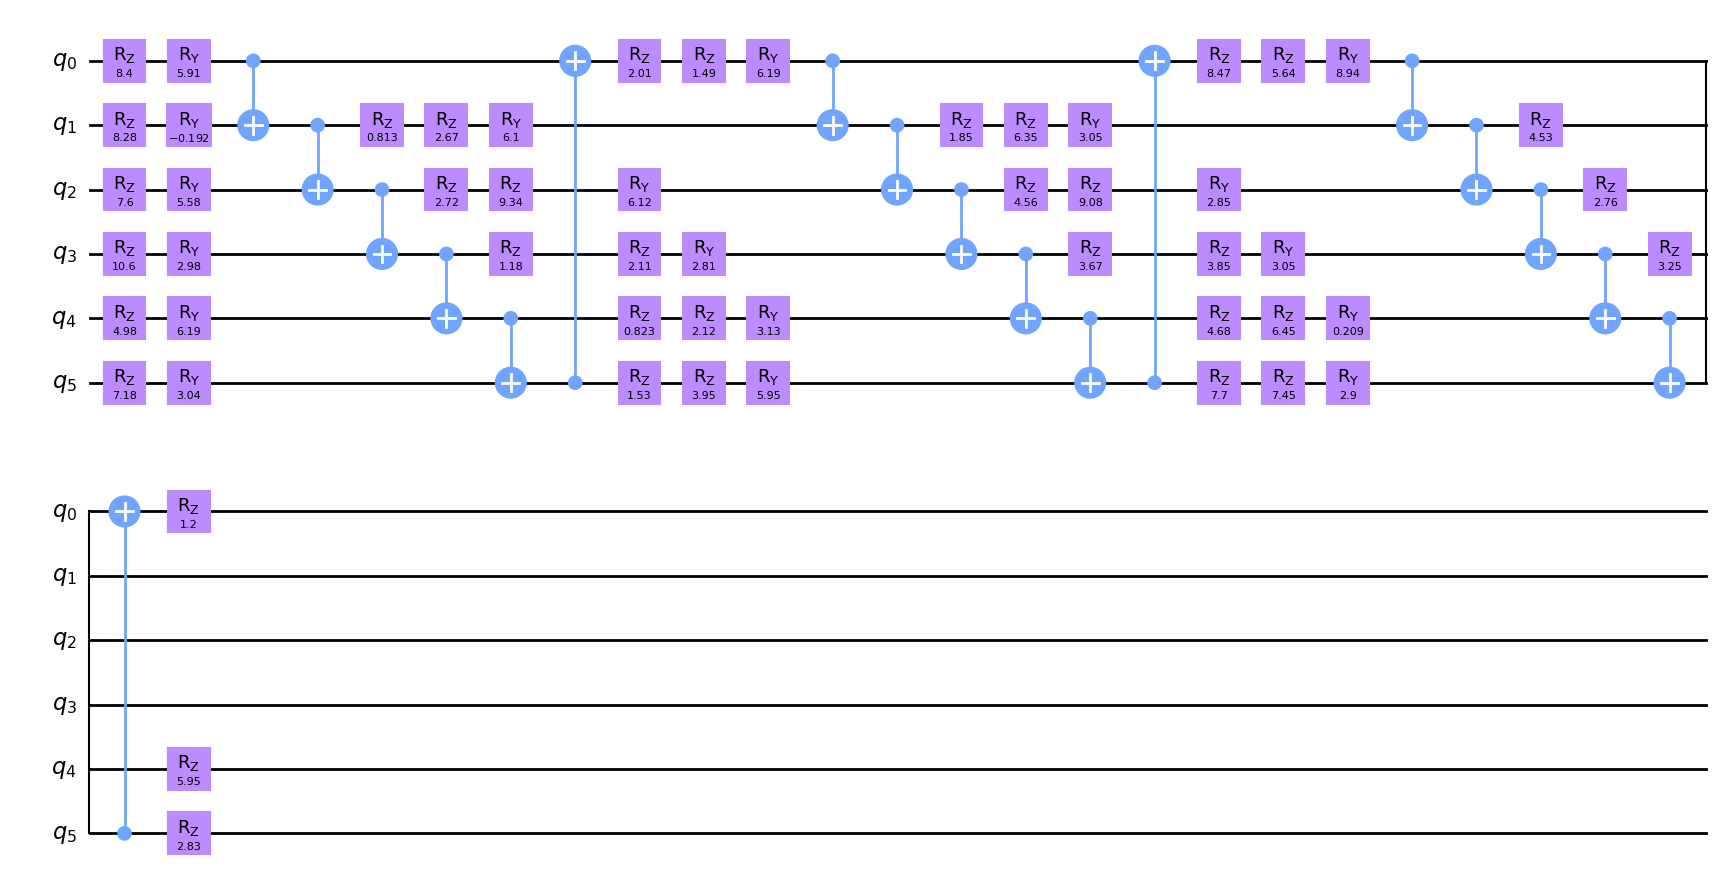


Optimizer: L_BFGS_B
Iterations: 0
Function evaluations: 1155
Elapsed time: 4.60 seconds
Best cost: 0.0

Best parameterized circuit:


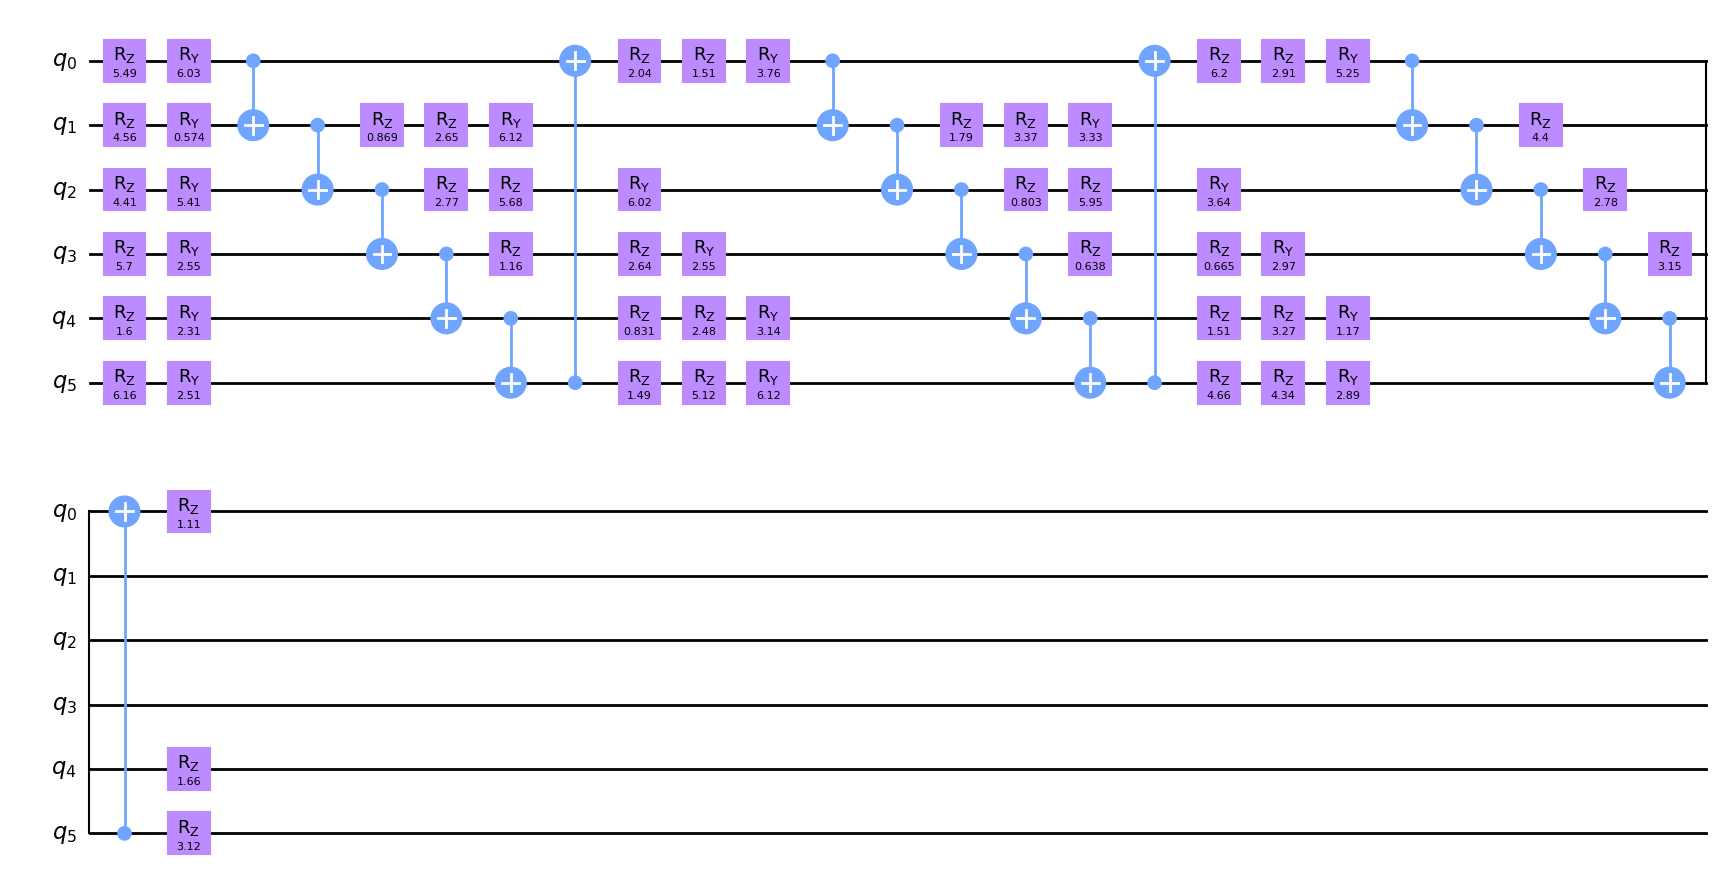


Optimizer: POWELL
Iterations: 0
Function evaluations: 1000
Elapsed time: 4.07 seconds
Best cost: 0.0

Best parameterized circuit:


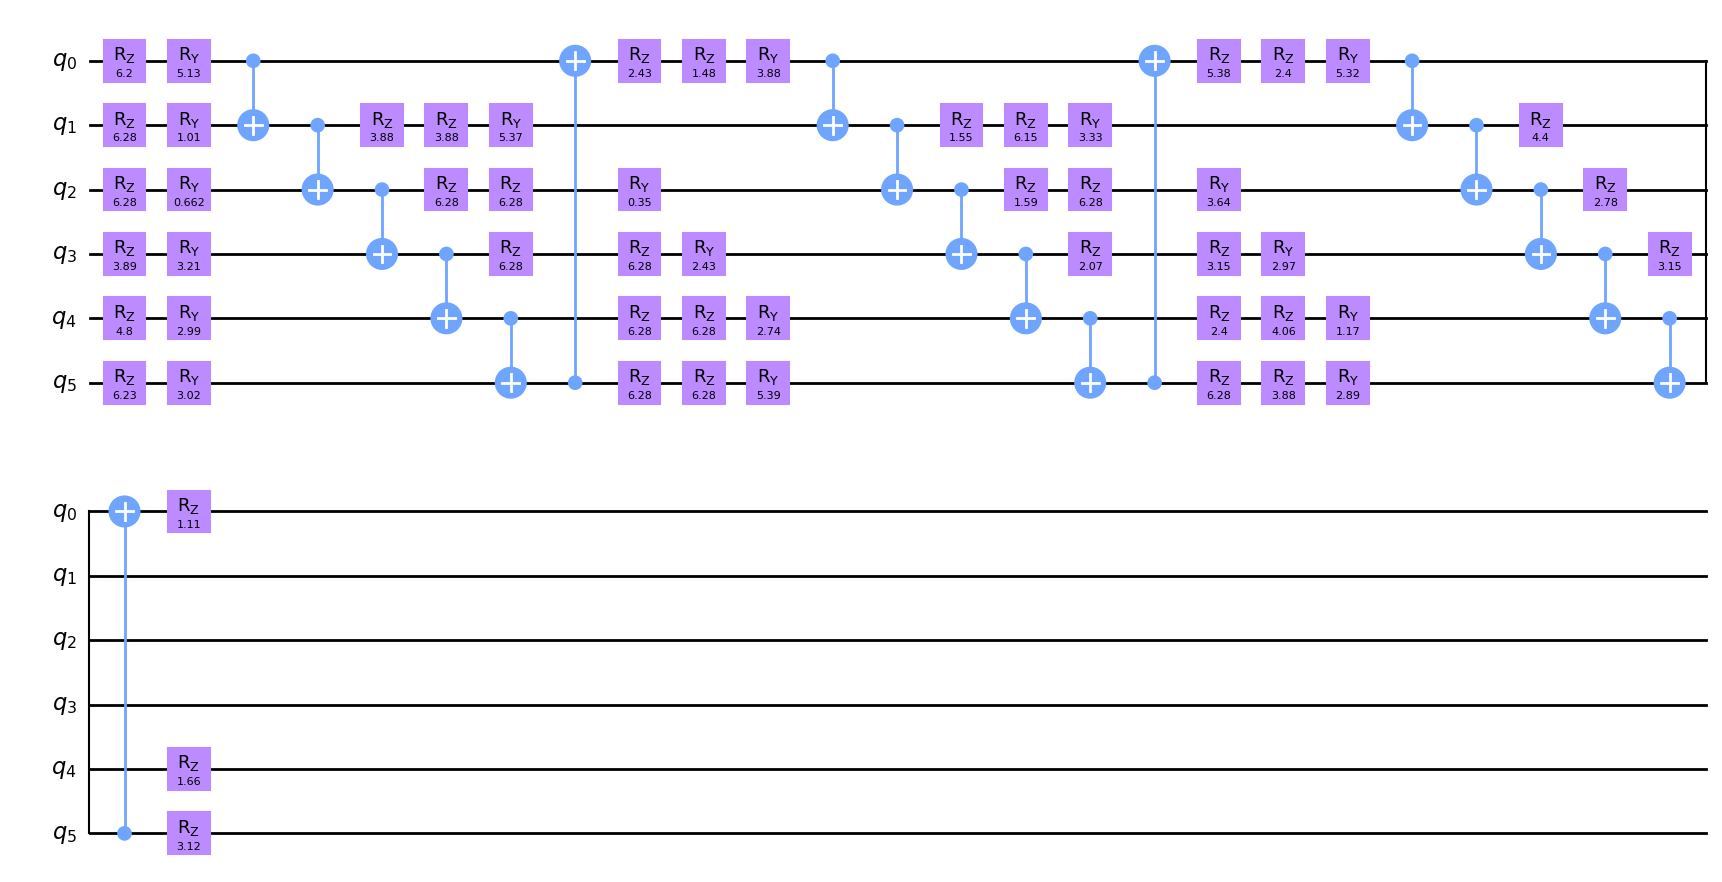


Optimizer: ADAM
Iterations: None
Function evaluations: 500
Elapsed time: 115.33 seconds
Best cost: 0.0

Best parameterized circuit:


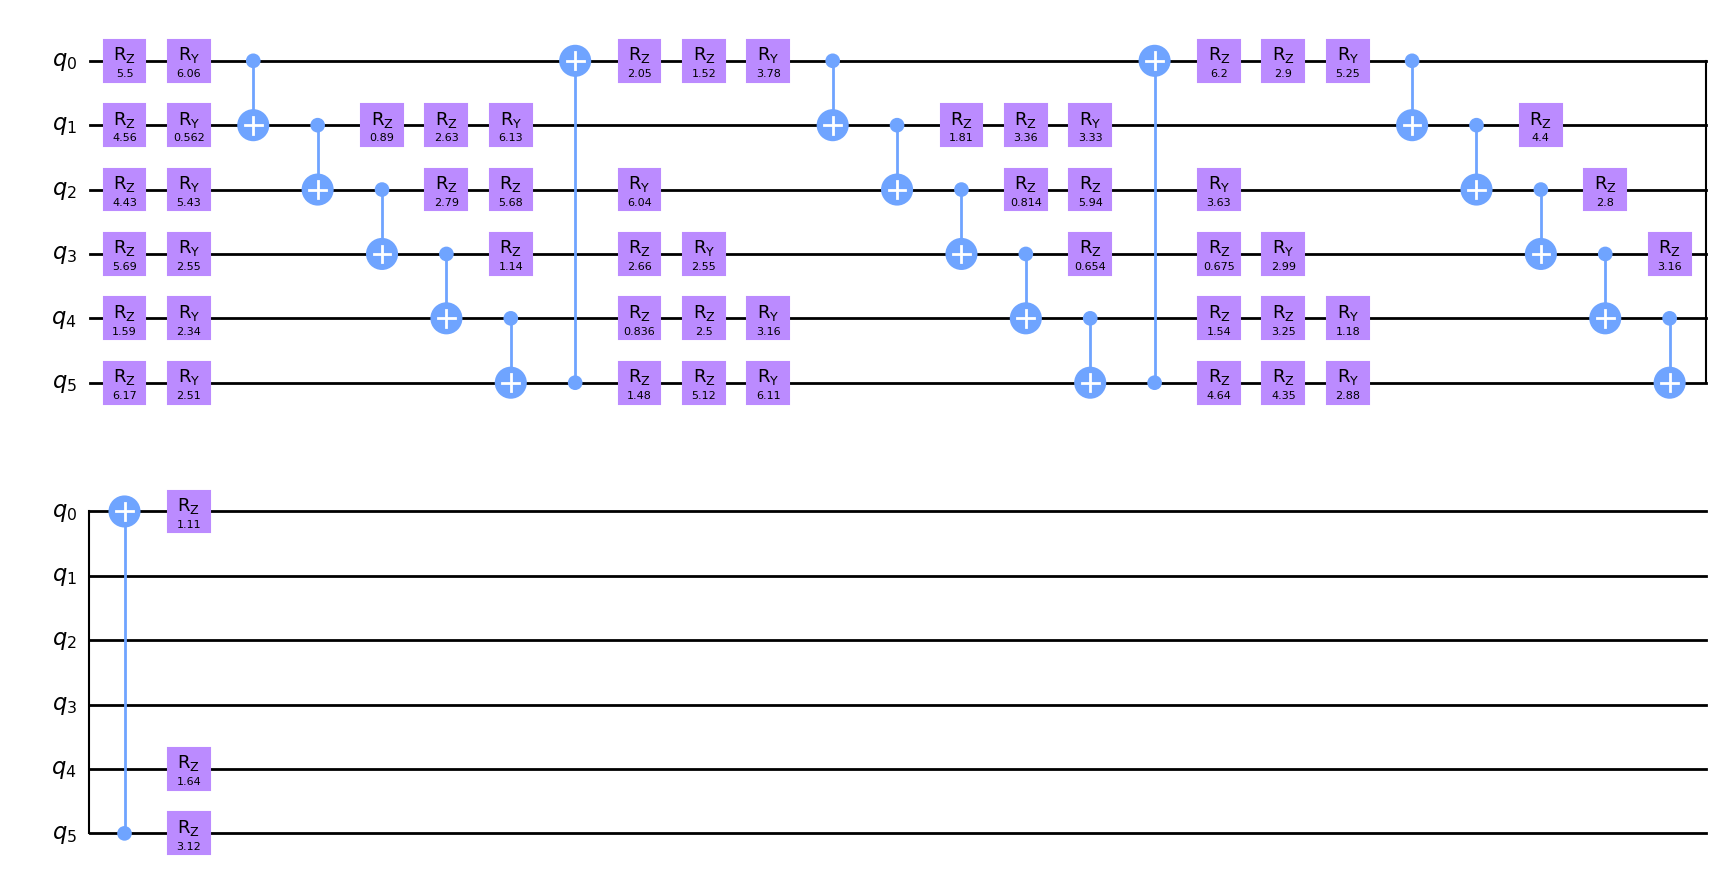


Optimizer: CG
Iterations: 0
Function evaluations: 1662
Elapsed time: 7.49 seconds
Best cost: 0.0

Best parameterized circuit:


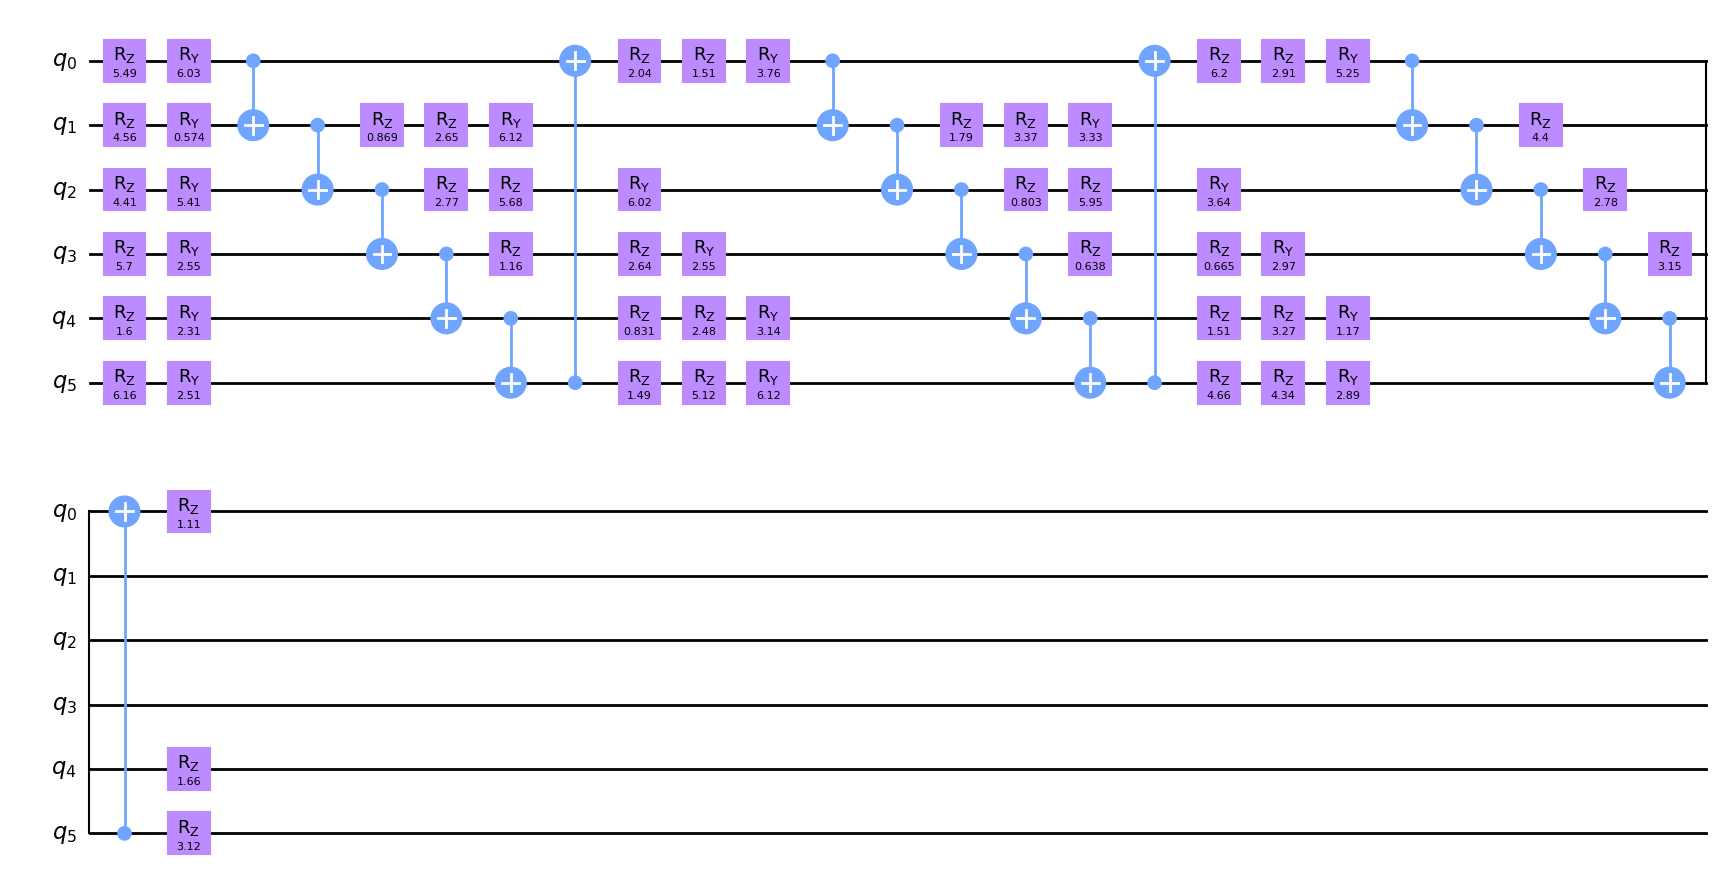


Optimizer: UMDA
Iterations: None
Function evaluations: 2100
Elapsed time: 10.68 seconds
Best cost: 0.0

Best parameterized circuit:


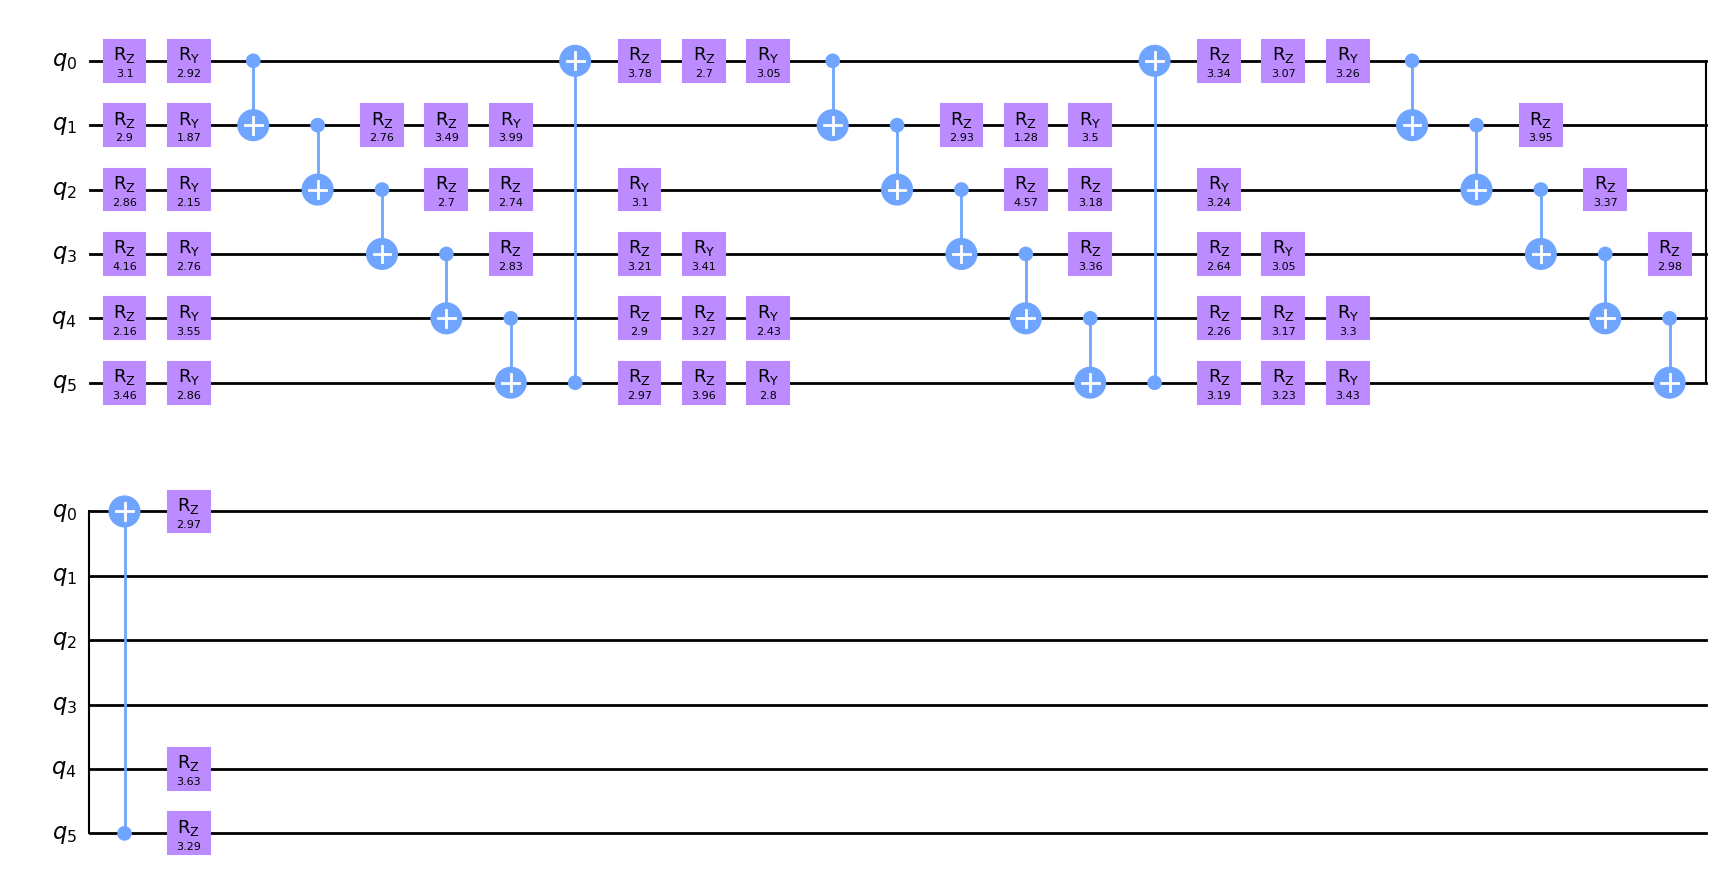

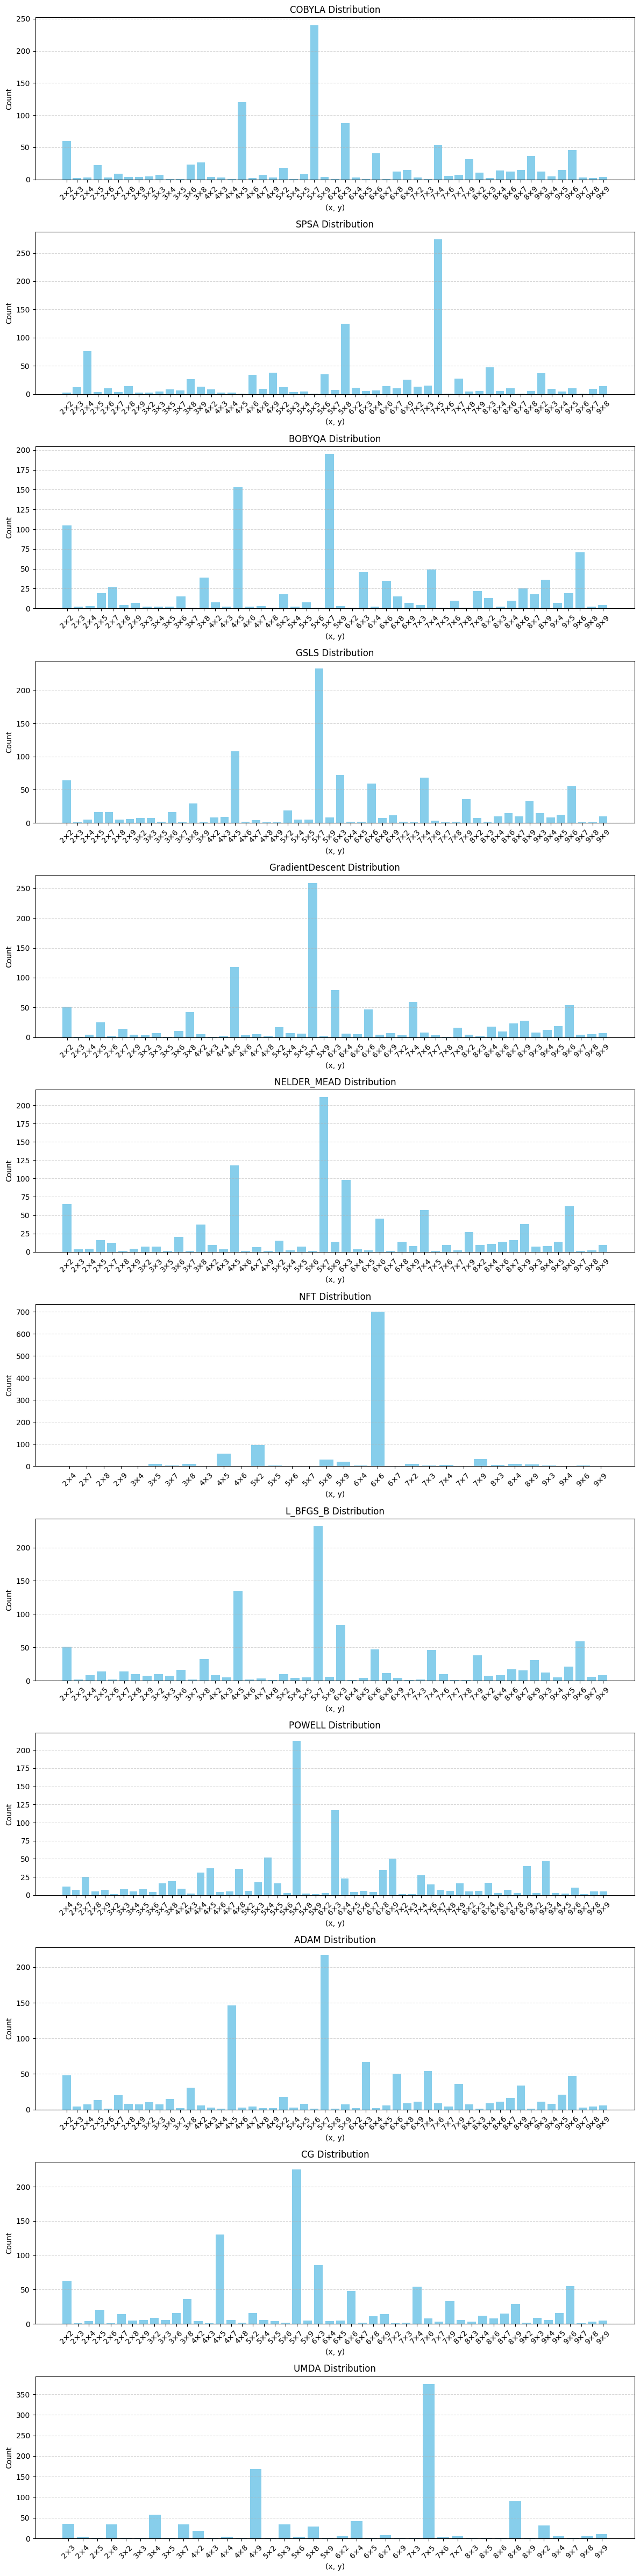


Top 5 most frequent (x, y) pairs for COBYLA:
x=5, y=7, count=240
x=4, y=5, count=120
x=6, y=3, count=88
x=2, y=2, count=60
x=7, y=4, count=53

Top 5 most frequent (x, y) pairs for SPSA:
x=7, y=5, count=274
x=5, y=8, count=125
x=2, y=4, count=76
x=8, y=3, count=47
x=4, y=9, count=38

Top 5 most frequent (x, y) pairs for BOBYQA:
x=5, y=7, count=195
x=4, y=5, count=153
x=2, y=2, count=105
x=9, y=6, count=71
x=7, y=4, count=49

Top 5 most frequent (x, y) pairs for GSLS:
x=5, y=7, count=233
x=4, y=5, count=108
x=6, y=3, count=72
x=7, y=4, count=68
x=2, y=2, count=64

Top 5 most frequent (x, y) pairs for GradientDescent:
x=5, y=7, count=259
x=4, y=5, count=118
x=6, y=3, count=79
x=7, y=4, count=59
x=9, y=6, count=54

Top 5 most frequent (x, y) pairs for NELDER_MEAD:
x=5, y=7, count=211
x=4, y=5, count=118
x=6, y=3, count=98
x=2, y=2, count=65
x=9, y=6, count=62

Top 5 most frequent (x, y) pairs for NFT:
x=6, y=6, count=700
x=5, y=2, count=97
x=4, y=5, count=58
x=7, y=9, count=33
x=5, y=8, c

In [7]:
# ------------------------------
# 5. Optimizer Evaluation
# ------------------------------

shared_init_theta = np.random.uniform(0, 2 * np.pi, len(params))     # initialize init_theta with random values

def run_qiskit_optimizer(optimizer, label="Qiskit", maxiter=200):    # run the Qiskit optimizer
    init_theta = shared_init_theta.copy()                            # copy the shared_init_theta to init_theta
    start = time.time()                                              # start the timer

    if hasattr(optimizer, "set_options"):                            # if the optimizer has a set_options method
        optimizer.set_options(maxiter=maxiter)                       # set the maxiter option

    try:
        result = optimizer.minimize(fun=expectation, x0=init_theta, bounds=[(0, 2 * np.pi)] * len(init_theta))
    except TypeError:
        result = optimizer.minimize(fun=expectation, x0=init_theta)  # minimize the cost function

    end = time.time()                                                # end the timer

    print(f"\nOptimizer: {label}")
    print("Iterations:", getattr(result, "nit", "N/A"))
    print("Function evaluations:", getattr(result, "nfev", "N/A"))
    # print("Success:", getattr(result, "success", "N/A"))
    # print("Message:", getattr(result, "message", "N/A"))
    print("Elapsed time: {:.2f} seconds".format(end - start))
    print("Best cost:", result.fun)

    bound_circuit = ansatz.assign_parameters({params[i]: result.x[i] for i in range(len(params))})
    print("\nBest parameterized circuit:")                           # assign the optimized parameters to the ansatz
    display(bound_circuit.draw("mpl"))                               # display the best parameterized circuit

    return result.fun

# ------------------------------
# 6. Main Execution
# ------------------------------

optimizers = [
    (COBYLA(maxiter=500), "COBYLA"),            # Constrained Optimization BY Linear Approximations
    (SPSA(maxiter=500), "SPSA"),                # Simultaneous Perturbation Stochastic Approximation
    (BOBYQA(maxiter=500), "BOBYQA"),            # Bound Optimization BY Quadratic Approximation
    (GSLS(maxiter=500), "GSLS"),                # Gaussian-smoothed Line Search
    (GradientDescent(maxiter=500), "GradientDescent"), 
    (NELDER_MEAD(maxiter=500), "NELDER_MEAD"),  # Nelder-Mead optimizer
    (NFT(maxiter=500), "NFT"),                  # Nakanishi–Fujii–Todo algorithm
    (L_BFGS_B(maxiter=500), "L_BFGS_B"),        # Limited-memory BFGS Bound
    (POWELL(maxiter=500), "POWELL"),            # Powell optimizer
    (ADAM(maxiter=500), "ADAM"),                # Adam and AMSGRAD optimizers
    (CG(maxiter=500), "CG"),                    # Conjugate Gradient
    (UMDA(maxiter=500), "UMDA")                 # Univariate Marginal Distribution Algorithm
]


results = {}                    # the cost results of each optimizer
xy_distributions = {}           # the distribution of (x,y) pairs of each optimizer

for optimizer, label in optimizers:                      # iterate through all optimizers
    final_xy_counter.clear()                             # clear the counter for the next execution
    cost = run_qiskit_optimizer(optimizer, label=label)  # run the Qiskit optimizer
    results[label] = cost                                # store the cost results
    xy_distributions[label] = dict(final_xy_counter)     # store the distribution of (x,y) pairs


# Plot each optimizer's result distribution as a histogram
fig, axs = plt.subplots(len(optimizers), 1, figsize=(12, 4 * len(optimizers)))
axs = axs.flatten()

for i, (_, label) in enumerate(optimizers):
    ax = axs[i]
    counter = dict(sorted(xy_distributions[label].items()))
    labels = [f"{x}×{y}" for (x, y) in counter]
    values = list(counter.values())
    ax.bar(labels, values, color='skyblue')
    ax.set_title(f"{label} Distribution")
    ax.set_ylabel("Count")
    ax.set_xlabel("(x, y)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Show top 5 results for each optimizer
from operator import itemgetter

for label in results:
    print(f"\nTop 5 most frequent (x, y) pairs for {label}:")
    sorted_results = sorted(xy_distributions[label].items(), key=itemgetter(1), reverse=True)  # in descending order
    for (x, y), c in sorted_results[:5]:
        print(f"x={x}, y={y}, count={c}")

In [8]:
import qiskit, qiskit_aer, qiskit_algorithms, matplotlib
print("Versions:")
print("Qiskit:", qiskit.__version__)
print("Qiskit_Aer:", qiskit_aer.__version__)
print("Qiskit_Algorithms.optimizers:", qiskit_algorithms.__version__)
print("Numpy:", np.__version__)
print("Matplotlib.pyplot:", matplotlib.__version__)


Versions:
Qiskit: 0.24.1
Qiskit_Aer: 0.12.0
Qiskit_Algorithms.optimizers: 0.2.1
Numpy: 1.23.5
Matplotlib.pyplot: 3.9.4
